In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.datasets import make_blobs
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5 , 0.5]
X, y = make_blobs( n_samples=[n_samples_1 , n_samples_2 ],
centers=centers,
cluster_std=clusters_std,
random_state=0, shuffle=False)

In [ ]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])



**Візуалізуємо отримані дані**

Як видно з візуалзізації, дані розбиті на два класи що пересікаються, і, в загальному випадку, не є роздільними



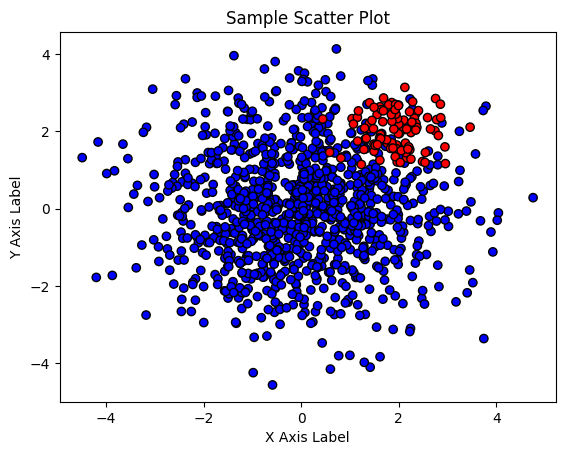

In [ ]:
colors = ['red' if i & 1 else 'blue' for i in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='black', linewidths=1)
plt.title("Sample Scatter Plot")
plt.xlabel("X Axis Label")
plt.ylabel("Y Axis Label")
plt.show()

In [ ]:
nu = [0.2, 0.4, 0.6, 0.8, 1]
degrees = [2, 3, 4, 5, 6]

model = NuSVC(kernel="poly")

**Виконаємо навчання моделі з емпіричними параметрами**

Оскільки датасет є незбалансованим, то при навчанні моделі використовується параметр class_weight='balanced'

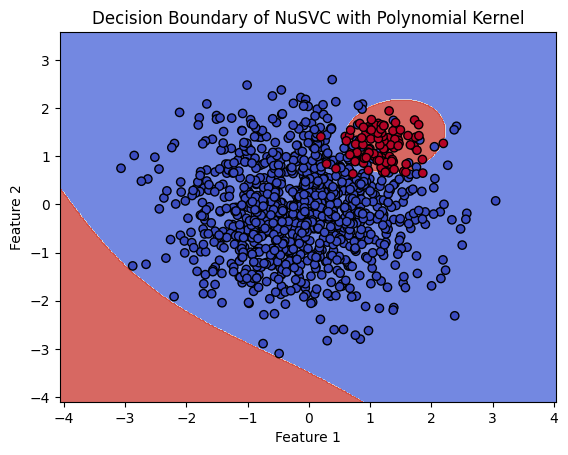

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a NuSVC model with a polynomial kernel
model = NuSVC(nu = 0.1, kernel='poly', degree=3, class_weight='balanced', coef0=1)
model.fit(X, y)
# model.fit(X, y, sample_weight=weights)


# Create a mesh grid to plot decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict over the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title("Decision Boundary of NuSVC with Polynomial Kernel")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Візуалізуємо як веде себе модель для різних параметрів nu, degree, coef0

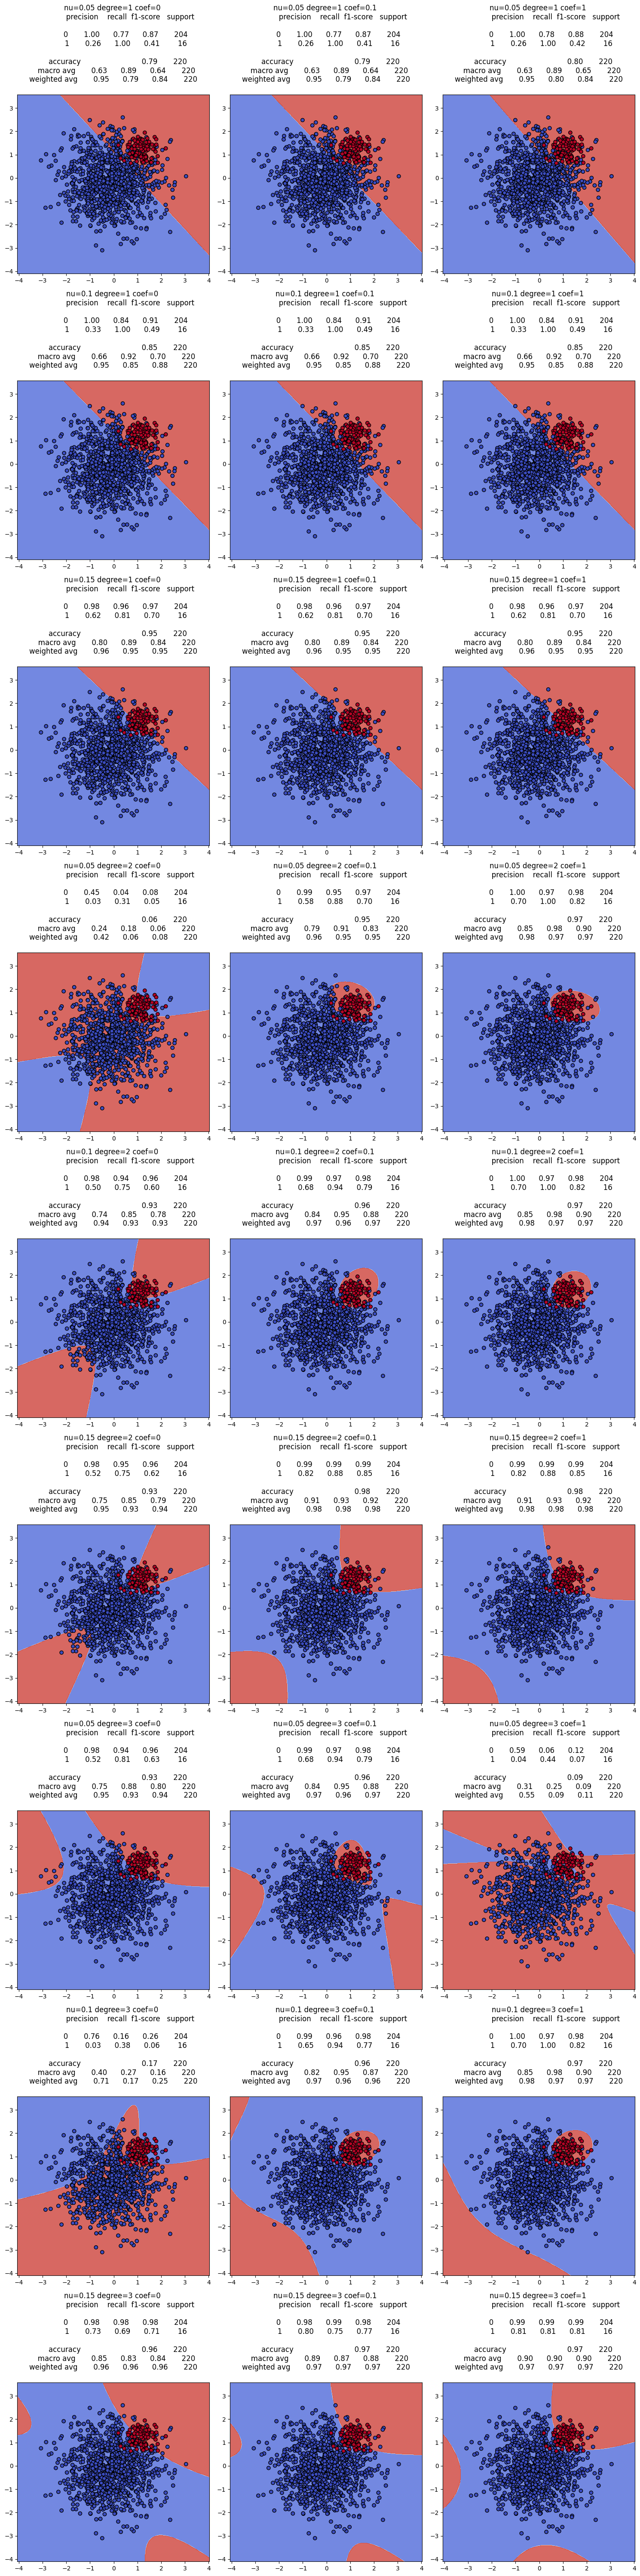

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import itertools

x = np.linspace(0, 10, 100)
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 60))

params = [
   [1, 2, 3],
   [0.05, 0.1, 0.15],
   [0, 0.1, 1]
]
params = itertools.product(*params)

axes = axes.flatten()

for ax, param in zip( axes, params ):
  degree, nu, coef = param

  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

  model = NuSVC(nu = nu, kernel='poly', degree=degree, class_weight='balanced', coef0=coef)
  model.fit(X_train, y_train)

  weights =  np.array( map(lambda x: 1 if x == 0 else 10, [*y_test]) )

  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred)


  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  score = model.score(X, y)
  score = truncate(score, 3)

  ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
  ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
  ax.set_title(f"""{nu=} {degree=} {coef=} \n {str(report)}""")

plt.tight_layout()
plt.show()


Виконаємо випадковий пошук оптимальних гіперпараметрів моделі

In [ ]:
from scipy.stats import uniform
param_dist = {
    'coef0': uniform(0, 1),  # Uniform distribution between 0.1 and 10
    'nu': uniform(0, 0.18),
    'degree': [1, 2, 3]
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=52)

In [ ]:
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="f1", n_iter=1000, cv=5, n_jobs=-1)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=NuSVC(class_weight='balanced', coef0=1,
                                   kernel='poly', nu=0.15),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'coef0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x797ca6f728c0>,
                                        'degree': [1, 2, 3],
                                        'nu': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x797ca6f5de10>},
                   scoring='f1')

In [ ]:
best_params_rand = randomized_search.best_params_
best_params_rand
# best_model_rand = randomized_search.best_estimator_

{'coef0': 0.9165171092721048, 'degree': 2, 'nu': 0.07918774448494553}

Візуалізуємо найкращу знайдену модель



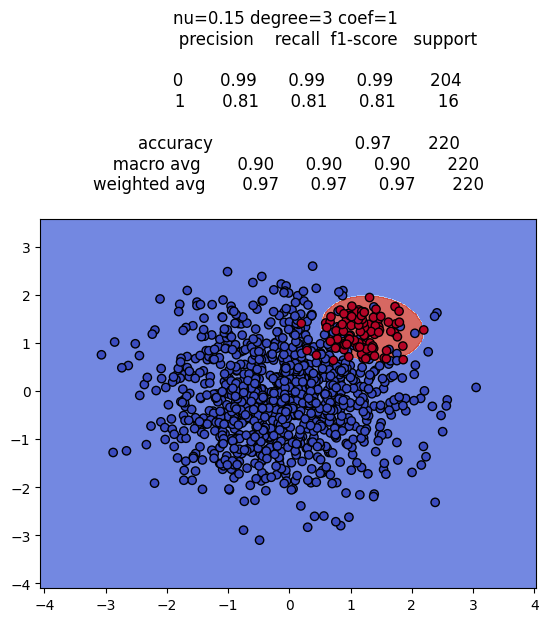

In [ ]:
Z = randomized_search.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

score = randomized_search.score(X, y)
score = truncate(score, 3)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title(f"""{nu=} {degree=} {coef=} \n {str(report)}""")

plt.show()

In [ ]:
y_pred = randomized_search.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[197,   5],
       [  2,  16]])

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

display = PrecisionRecallDisplay.from_estimator(
    randomized_search, X_test, y_test, name="NuSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    randomized_search, X_test, y_test,
    name="ROC curve",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
)
# roc_curve(y_test, y_score[:, 0])

In [ ]:
from sklearn.datasets import load_wine
import pandas as pd
df = load_wine(as_frame=True)
X, y = load_wine(return_X_y=True)
X.shape

In [ ]:
df = pd.DataFrame(data=np.c_[df['data'], df['target']],
                     columns= df['feature_names'] + ['target'])

In [ ]:
df

Оскільки вхідні дані мають велику розмірність, то візуалізувати їх як в першому прикладі неможливо. Тому для розуміння природи даних краще зообразити гістограми розподілу окремих параметрів

In [ ]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52, test_size=0.2)
model = NuSVC(nu = 0.1, kernel='poly', degree=4, coef0=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {"nu": [0.1*i for i in range(1, 9)], "degree": [i for i in range(1, 6)], "coef0": [0.1*i for i in range(1, 10)]}
grd_srch = GridSearchCV(model, param_grid=params, scoring="f1_macro", n_jobs=-1, refit=True, verbose=3, error_score="raise")
grd_srch.fit(X_train, y_train)
print(grd_srch.best_params_, "\n", grd_srch.best_score_)

In [ ]:
y_pred = grd_srch.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
param_dist = {
    'coef0': uniform(0, 1),  # Uniform distribution between 0.1 and 10
    'nu': uniform(0, 0.18),
    'degree': [1, 2, 3, 4, 5]
}
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="f1_macro", n_iter=1000, cv=5, n_jobs=-1, error_score="raise")
randomized_search.fit(X_train, y_train)
print(randomized_search.best_params_, "\n", randomized_search.best_score_)

In [ ]:
y_pred = randomized_search.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
confusion_matrix(y_test, y_pred, normalize="true")

In [ ]:
model = NuSVC(nu = 0.1, kernel='poly', degree=4, coef0=1, probability=True)
params = {"nu": [0.1*i for i in range(1, 9)], "degree": [i for i in range(1, 6)], "coef0": [0.1*i for i in range(1, 10)]}
grd_srch = GridSearchCV(model, param_grid=params, scoring="f1_macro", n_jobs=-1, refit=True, verbose=3, error_score="raise")
grd_srch.fit(X_train, y_train)
print(grd_srch.best_params_, "\n", grd_srch.best_score_)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

y_score = grd_srch.predict_proba(X_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(grd_srch)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

In [ ]:
from collections import Counter

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(plot_chance_level=True)
_ = display.ax_.set_title("Micro-averaged over all classes")